look at why we get weird blocking of the top results from our first semmeddb full prediction run

In [1]:
import pandas as pd
from scipy import spatial
import numpy

from tqdm import tqdm
import seaborn as sns

In [2]:
%matplotlib inline

## read data

In [3]:
res = pd.read_csv("all_pairs_results_test.tsv", sep='\t')

In [4]:
res.shape

(500000, 7)

In [5]:
res.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,105788,51643,0.999978,C0667286,metabotropic glutamate receptor 4,C0234213,Sensory denervation disorder
1,36688,51643,0.999886,C0107103,Brain-Derived Neurotrophic Factor,C0234213,Sensory denervation disorder
2,10474,4273,0.999834,C0031304,Phage Receptors,C0012624,Discitis
3,207,51643,0.999812,C0001041,Acetylcholine,C0234213,Sensory denervation disorder
4,55073,51643,0.999735,C0248336,R-cadherin,C0234213,Sensory denervation disorder


the blocking thing i was witnessing earlier was probably because i wasn't sorting the results by descending pscore

seems to go away now, which is good?

---

In [6]:
def get_simple_features(fname):
    """Get a dictionary of embeddings for all nodes.
    Faster than iterrowing the feature dataframe by 4x
    """

    res = dict()
    with open(fname, "r") as fin:
        nodes = int(fin.readline().split(" ")[0])

        for line in tqdm(fin, total=210389):
            vals = line.rstrip("\n").split(" ")

            uid = int(vals[0])
            res[uid] = list(map(float, vals[1:]))
            
    return res

In [7]:
sfeats = get_simple_features("data/embeddings/sem50walk128vec10window.txt")

100%|██████████| 210389/210389 [00:08<00:00, 24617.44it/s]


In [8]:
def convolv(chemuid, diseuid):
    """Get convolved features."""
    return [
        sfeats[chemuid][i] * sfeats[diseuid][i]
        for i in range(vecsize)
    ]

---

In [9]:
def similarity(u, v):
    return 1 - spatial.distance.cosine(u, v)

In [10]:
res.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name
0,105788,51643,0.999978,C0667286,metabotropic glutamate receptor 4,C0234213,Sensory denervation disorder
1,36688,51643,0.999886,C0107103,Brain-Derived Neurotrophic Factor,C0234213,Sensory denervation disorder
2,10474,4273,0.999834,C0031304,Phage Receptors,C0012624,Discitis
3,207,51643,0.999812,C0001041,Acetylcholine,C0234213,Sensory denervation disorder
4,55073,51643,0.999735,C0248336,R-cadherin,C0234213,Sensory denervation disorder


In [11]:
tmp = list()
vecsize = 128

for cuid, duid in tqdm(zip(res["chem_uid"], res["dise_uid"]), total=len(res)):
    simval = similarity(sfeats[cuid], sfeats[duid])
    
    tmp.append(simval)

100%|██████████| 500000/500000 [00:28<00:00, 17448.06it/s]


In [12]:
res = res.assign(pairsim = tmp)

## does similarity of the chemical and disease affect probability of being ranked highly?

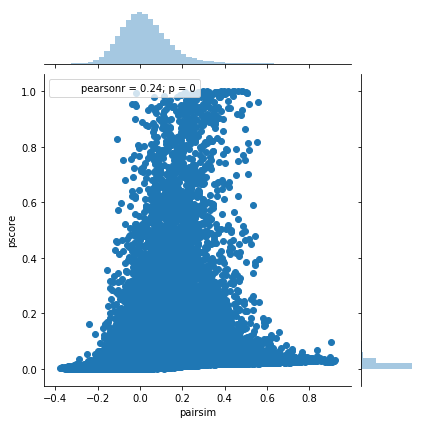

In [13]:
sns.jointplot(data=res, x="pairsim", y="pscore")

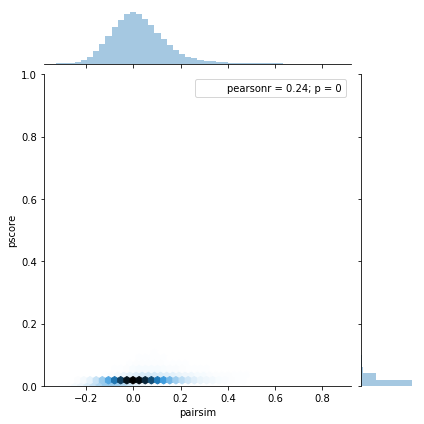

In [14]:
sns.jointplot(data=res, x="pairsim", y="pscore", kind="hex")

## similarity to the top result and probability of being ranked highly?

In [15]:
best = res.query("pscore > 0.7")

vecsize = 128

tmp = list()

# top result
topfeats = convolv(105788, 51643)

for cuid, duid in zip(best["chem_uid"], best["dise_uid"]):
    fvec = convolv(cuid, duid)
    
    tmp.append([cuid, duid, similarity(topfeats, fvec)])
    
tmp = pd.DataFrame(tmp, columns=["chem_uid", "dise_uid", "similarity"])

---

In [16]:
fin = best.merge(tmp, how="inner", on=["chem_uid", "dise_uid"])

In [17]:
fin.head()

,chem_uid,dise_uid,pscore,chem_id,chem_name,dise_id,dise_name,pairsim,similarity
0,105788,51643,0.999978,C0667286,metabotropic glutamate receptor 4,C0234213,Sensory denervation disorder,0.481384,1.000000
1,36688,51643,0.999886,C0107103,Brain-Derived Neurotrophic Factor,C0234213,Sensory denervation disorder,0.382870,0.645157
2,10474,4273,0.999834,C0031304,Phage Receptors,C0012624,Discitis,0.460870,0.269522
3,207,51643,0.999812,C0001041,Acetylcholine,C0234213,Sensory denervation disorder,0.317773,0.550173
4,55073,51643,0.999735,C0248336,R-cadherin,C0234213,Sensory denervation disorder,0.415925,0.559718


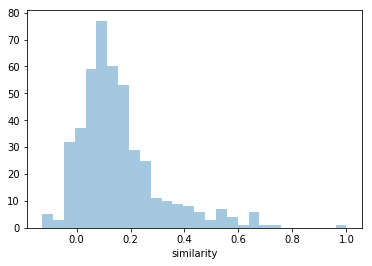

In [18]:
sns.distplot(fin["similarity"], kde=False)

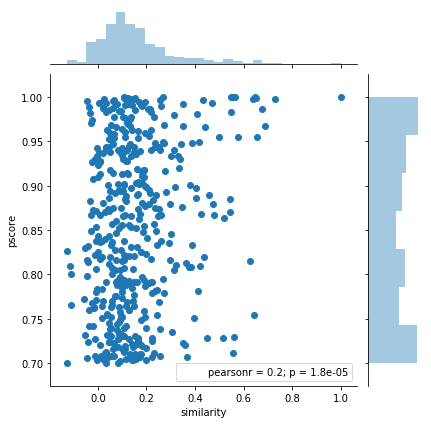

In [19]:
sns.jointplot(data=fin, x="similarity", y="pscore")

for the top results i'm not seeing any sort of obvious correlation between the top result and the ranking

maybe it's time to look at a more random sampling like andrew said